<a href="https://colab.research.google.com/github/solobala/FEML23/blob/master/FEML23_DZ3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашняя работа «Оценка точности модели, переобучение, регуляризация» обновленное

## Цель: закрепить знания о математическом смысле метрик TPR, FPR. Изучить построение ROC-кривой, графика Precision-Recall.
Описание задания:
Решить задачу классификации при помощи обучения модели логистической регрессии. Качество модели оценивается путем подсчета метрик TPR, FPR и построения графиков ROC-кривой, Precision-Recall. Данные для обучения модели хранятся в файле athletes.csv, который можно найти в материалах к занятию.

**target - пол спортсмена. **

## Этапы работы:

### Импорт библиотек и загрузка датасета

In [ ]:
from zipfile import ZipFile # Загрузка данных
import fnmatch
import os
import numpy as np
import pandas as pd

from datetime import datetime,timedelta
from dateutil.parser import parse as du_parse
from dateutil.relativedelta import relativedelta

import scipy.stats as sts

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


from sklearn.model_selection import  RandomizedSearchCV # библиотека для оптимизации гиперпараметров
from sklearn.impute import SimpleImputer # библиотека для заполнения пропусков  в данных
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # библиотека для кодирования категриальных переменных
from sklearn.preprocessing import StandardScaler # библиотека для нормализации номинальных признаков
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, chi2

from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score


import matplotlib.pyplot as plt

np.random.seed(0)

In [ ]:
!wget -O"dz_3.zip" "https://u.netology.ru/backend/uploads/lms/attachments/files/data/26021/ноутбук_и_дополнительнае_материалы-_Оценка_точности_модели__переобучение__регуляризация.zip"   # Качаем архив выбранного датасета

with ZipFile('dz_3.zip', 'r') as zip_file:  
    print(zip_file.infolist())
    for item in zip_file.infolist():
      if fnmatch.fnmatch(item.filename, '*athletes.csv'):

        zip_file.extract(item.filename)
        os.rename(item.filename,"athletes.csv")

--2023-03-31 17:30:48--  https://u.netology.ru/backend/uploads/lms/attachments/files/data/26021/%D0%BD%D0%BE%D1%83%D1%82%D0%B1%D1%83%D0%BA_%D0%B8_%D0%B4%D0%BE%D0%BF%D0%BE%D0%BB%D0%BD%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%B0%D0%B5_%D0%BC%D0%B0%D1%82%D0%B5%D1%80%D0%B8%D0%B0%D0%BB%D1%8B-_%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D1%82%D0%BE%D1%87%D0%BD%D0%BE%D1%81%D1%82%D0%B8_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8__%D0%BF%D0%B5%D1%80%D0%B5%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5__%D1%80%D0%B5%D0%B3%D1%83%D0%BB%D1%8F%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F.zip
Resolving u.netology.ru (u.netology.ru)... 213.180.193.247, 2a02:6b8::1da
Connecting to u.netology.ru (u.netology.ru)|213.180.193.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1005262 (982K) [application/x-zip-compressed]
Saving to: ‘dz_3.zip’

dz_3.zip            100%[===================>] 981.70K  1.23MB/s    in 0.8s    

2023-03-31 17:30:50 (1.23 MB/s) - ‘dz_3.zip’ saved [1005262/1005262]

[<Zi

### 1. Преобразование данных

In [ ]:
data = pd.read_csv('athletes.csv')
data.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [ ]:
data = data.drop_duplicates()
data.shape # дубликатов нет

(11538, 11)

In [ ]:
# пропуски - в столбцах height, weight и dob - составляют менее 6%
len(data[pd.isnull( data['height']) | pd.isnull(data['weight']) | pd.isnull(data['dob']) ])/data.shape[0]*100

5.893569076096377

In [ ]:
# Категориальные features - определяем по типу object. Вместе с target их 9
cat_features = data.select_dtypes("object").columns
print(*cat_features, sep=", ")

name, nationality, sex, dob, sport


In [ ]:
# Количественные features - определяем по типу numeric
numerical_features = data.select_dtypes("number").columns
print(*numerical_features, sep=", ")

id, height, weight, gold, silver, bronze


#### Работа с пропусками

Удалим строки, в которых пропущены значения 2 и более признаков. Далее сделаем дополнительный столбец 'imt' - индекс массы тела. Заполняем пропущенные значения, используем библиотеку SimpleImputer

In [ ]:
data[pd.isnull(data['dob'])].head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
8546,663676373,Pavel Sozykin,RUS,male,NaN,NaN,NaN,sailing,0,0,0


In [ ]:
# В этой строке стразу 3 пропуска, и она такая одна. Просто удалим ее
data = data.drop(index=8546)

In [ ]:
def age(x):
  a = datetime.strptime(x,'%m/%d/%y')
  delta = timedelta(days=36520, 
                           seconds=0, 
                           microseconds=0, 
                           milliseconds=0, 
                           minutes=0, 
                           hours=0, 
                           weeks=0)
  if a.year > datetime.today().year:
    a-=delta
  return datetime.today().year-a.year

In [ ]:
# введем еще один признак - возраст ( это номинальный, который заменит порядковый dob)
data['age'] = data['dob'].apply(age)
data.drop(columns=['dob'], inplace=True)
data.head()

,id,name,nationality,sex,height,weight,sport,gold,silver,bronze,age
0,736041664,A Jesus Garcia,ESP,male,1.72,64.0,athletics,0,0,0,54
1,532037425,A Lam Shin,KOR,female,1.68,56.0,fencing,0,0,0,37
2,435962603,Aaron Brown,CAN,male,1.98,79.0,athletics,0,0,1,31
3,521041435,Aaron Cook,MDA,male,1.83,80.0,taekwondo,0,0,0,32
4,33922579,Aaron Gate,NZL,male,1.81,71.0,cycling,0,0,0,33


In [ ]:
# удалим также строки, где одновременно пропущены и рост, и вес (сколько их?) Менее 3 %
len(data[pd.isnull( data['height']) & pd.isnull(data['weight'])])/data.shape[0]*100

2.669671491722285

In [ ]:
data = data[~(pd.isnull( data['height']) & pd.isnull(data['weight']))]

In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11229 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11229 non-null  int64  
 1   name         11229 non-null  object 
 2   nationality  11229 non-null  object 
 3   sex          11229 non-null  object 
 4   height       11208 non-null  float64
 5   weight       10879 non-null  float64
 6   sport        11229 non-null  object 
 7   gold         11229 non-null  int64  
 8   silver       11229 non-null  int64  
 9   bronze       11229 non-null  int64  
 10  age          11229 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


#### Работа с номинальными признаками

In [ ]:
data.head()

,id,name,nationality,sex,height,weight,sport,gold,silver,bronze,age
0,736041664,A Jesus Garcia,ESP,male,1.72,64.0,athletics,0,0,0,54
1,532037425,A Lam Shin,KOR,female,1.68,56.0,fencing,0,0,0,37
2,435962603,Aaron Brown,CAN,male,1.98,79.0,athletics,0,0,1,31
3,521041435,Aaron Cook,MDA,male,1.83,80.0,taekwondo,0,0,0,32
4,33922579,Aaron Gate,NZL,male,1.81,71.0,cycling,0,0,0,33


In [ ]:
def firstname(name):
  names = name.split(' ')
  first_name=' '.join(names[:-1])
  return first_name

In [ ]:
# Заменим признак name на firs_nameЮ т.к мы прогнозируем пол спортсмена, а имя более значимый признак при определении пола, чем имя и фамилия
data['first_name']=data['name'].apply(firstname)

In [ ]:
data.head()

,id,name,nationality,sex,height,weight,sport,gold,silver,bronze,age,first_name
0,736041664,A Jesus Garcia,ESP,male,1.72,64.0,athletics,0,0,0,54,A Jesus
1,532037425,A Lam Shin,KOR,female,1.68,56.0,fencing,0,0,0,37,A Lam
2,435962603,Aaron Brown,CAN,male,1.98,79.0,athletics,0,0,1,31,Aaron
3,521041435,Aaron Cook,MDA,male,1.83,80.0,taekwondo,0,0,0,32,Aaron
4,33922579,Aaron Gate,NZL,male,1.81,71.0,cycling,0,0,0,33,Aaron


In [ ]:
y=data.sex


In [ ]:
X=data.drop(columns=['id','name', 'sex'])
X.head()

,nationality,height,weight,sport,gold,silver,bronze,age,first_name
0,ESP,1.72,64.0,athletics,0,0,0,54,A Jesus
1,KOR,1.68,56.0,fencing,0,0,0,37,A Lam
2,CAN,1.98,79.0,athletics,0,0,1,31,Aaron
3,MDA,1.83,80.0,taekwondo,0,0,0,32,Aaron
4,NZL,1.81,71.0,cycling,0,0,0,33,Aaron


In [ ]:
# Произведем Label-кодирование признака 'sex'
le = LabelEncoder()
le.fit(y)
y = pd.Series(data=le.transform(y))

In [ ]:
y.value_counts() # практически сбалансированы

1    6153
0    5076
dtype: int64

In [ ]:
numeric_features = ["height", "weight","age"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ["nationality", "sport", "first_name"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)        
    

In [ ]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(max_iter=1000))]
)





In [ ]:
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['height', 'weight', 'age']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x7f98b83c5b80>))]),
                                                  ['nationality', 'sport',
                                                   'first_name'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

### 2. Разделение выборку на обучающее (80% данных) и тестовое (20% данных) подмножества

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [ ]:
clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.858


Выполним оптимизацию гиперпараметров с помощью RandomizedSearchCV. Мы будем искать как стратегию заполнения пропусков в  предварительной обработке номинальных признаков, так и параметр регуляризации логистической регрессии. RandomizedSearchCV случайным образом выбирает фиксированное количество настроек параметров, настроенных с помощью n_iter

In [ ]:
param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "preprocessor__cat__selector__percentile": [10, 30, 50, 70],
    "classifier__C": [0.1, 1.0, 10, 100],
}

search_cv = RandomizedSearchCV(clf, param_grid, n_iter=10, random_state=0)
search_cv

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['height',
                                                                                'weight',
                                                                                'age']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore')),
                                                                                               ('selector',
                                                                                                SelectPercentile(percentile=50,
                                                                                                                 score_func=<function chi2 at 0x7f98b83c5b80>))]),
                                                                               ['nationality',
                                                                                'sport',
                                                                                'first_name'])])),
                                             ('classifier',
                                              LogisticRegression(max_iter=1000))]),
                   param_distributions={'classifier__C': [0.1, 1.0, 10, 100],
                                        'preprocessor__cat__selector__percentile': [10,
                                                                                    30,
                                                                                    50,
                                                                                    70],
                                        'preprocessor__num__imputer__strategy': ['mean',
                                                                                 'median']},
                   random_state=0)

In [ ]:
# Вызов «обучения» запускает перекрестный поиск наилучшей комбинации гиперпараметров:
search_cv.fit(X_train, y_train)

print("Best params:")
print(search_cv.best_params_)

Best params:
{'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__cat__selector__percentile': 70, 'classifier__C': 10}


In [ ]:
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results[
    [
        "mean_test_score",
        "std_test_score",
        "param_preprocessor__num__imputer__strategy",
        "param_preprocessor__cat__selector__percentile",
        "param_classifier__C",
    ]
].head(5)

,mean_test_score,std_test_score,param_preprocessor__num__imputer__strategy,param_preprocessor__cat__selector__percentile,param_classifier__C
1,0.874430,0.004044,mean,70,10
7,0.872760,0.006354,mean,30,100
8,0.868753,0.007268,mean,50,10
5,0.856730,0.004363,mean,70,1.0
2,0.855951,0.005458,mean,30,1.0


In [ ]:
print(
    "accuracy of the best model from randomized search: "
    f"{search_cv.score(X_test, y_test):.3f}"
)

accuracy of the best model from randomized search: 0.875


In [ ]:
predictions = search_cv.predict(X_test)


In [ ]:
pred_proba = search_cv.predict_proba(X_test)

In [ ]:
from sklearn.metrics import recall_score, precision_score

In [ ]:
precision_score(y_test, predictions)

0.8536770280515542

In [ ]:
recall_score(y_test, predictions)

0.9282769991755977

In [ ]:
# Просто для практики - расчет метрик качества вручную
tp = 0 # True positive
fp = 0 # False positive
fn = 0 # False negative
tn = 0 # True negative

predictions = search_cv.predict_proba( X_test )
for predicted_prob, actual in zip( predictions[:, 1], y_test ):    
    if predicted_prob >= 0.5:
        predicted = 1
    else:
        predicted = 0
    
    if predicted == 1:
        if actual == 1:
            tp += 1
        else:
            fp += 1
    
    else:
        if actual == 1:
            fn += 1
        else:
            tn += 1

In [ ]:
pred=search_cv.predict(X_test)

In [ ]:
tp, fp, fn, tn

(1126, 193, 87, 840)

In [ ]:
# какая точность получилась?
(tp + tn) / (tp + fp + fn + tn)

0.8753339269813001

In [ ]:
precision = tp / (tp + fp) # доля правильно предсказанных среди причисленных моделью к категории 1
precision

0.8536770280515542

In [ ]:
recall = tp / (tp + fn) # Recall − доля правильно предсказанные среди Реальной категории 1
recall

0.9282769991755977

In [ ]:
fpr = fp/(fp + tn) # доля неправильно предсказанных среди относящихся к категории 0

fpr

0.1868344627299129

### 3. Построение ROC-кривой с помощью функции sklearn.metrics.roc_curve.

In [ ]:
# посчитаем ROC-кривую (Receiver Operating Characteristic)
from sklearn.metrics import roc_curve

In [ ]:
# получаем значения false и true positive rate для различных значений порога
fpr, tpr, thres = roc_curve( y_test, predictions[:, 1] )

In [ ]:
for line in zip( fpr[:10], tpr[:10], thres[:10] ):
    print( line )

(0.0, 0.0, 1.9999910383390707)
(0.0, 0.0008244023083264633, 0.9999910383390708)
(0.0, 0.07996702390766694, 0.9985757529871959)
(0.000968054211035818, 0.07996702390766694, 0.9985752439682749)
(0.000968054211035818, 0.08244023083264633, 0.9985062291208803)
(0.001936108422071636, 0.08244023083264633, 0.9984832726163773)
(0.001936108422071636, 0.10057708161582853, 0.9981088189805695)
(0.002904162633107454, 0.10057708161582853, 0.9980864246926623)
(0.002904162633107454, 0.10140148392415499, 0.9980658679848564)
(0.003872216844143272, 0.10140148392415499, 0.9980610120610677)


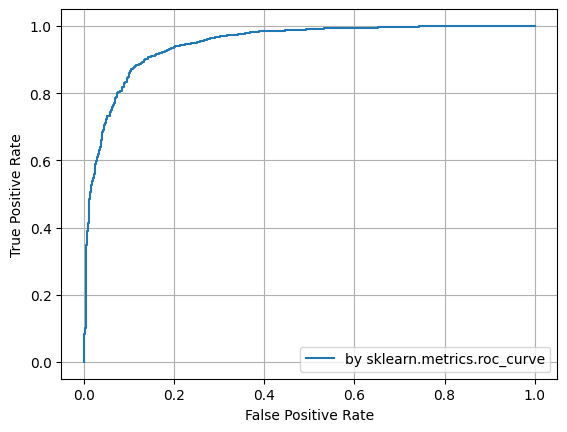

In [ ]:
plt.plot( fpr, tpr,  label = 'by sklearn.metrics.roc_curve' )
plt.legend( loc = 0 )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()

### 4. Вычисление значения ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score( y_test, predictions[:, 1] )

0.9464042731652659

In [ ]:
# Можно посчитать с помощью более общего метода auc
from sklearn.metrics import auc
auc( fpr, tpr )

0.9464042731652659

### 5. Реализация подсчета метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn

In [ ]:
def check(X_test, y_test, treshold):
  """
  Ф-я в качестве аргументов на вход принимает массив значений 
  признаков тестовой выборки X_test, 
  истинное значение (y_test) и порог (threshold).
  Возвращает значения метрик precision, recall, fpr
  """
  tp = 0 # True positive
  fp = 0 # False positive
  fn = 0 # False negative
  tn = 0 # True negative

  predictions = clf.predict_proba( X_test )
  for predicted_prob, actual in zip( predictions[:, 1], y_test ):    
      if predicted_prob >= treshold:
          predicted = 1
      else:
          predicted = 0
      
      if predicted == 1:
          if actual == 1:
              tp += 1
          else:
              fp += 1
      
      else:
          if actual == 1:
              fn += 1
          else:
              tn += 1
  precision = tp / (tp + fp + 1e-09)
  recall = tp / (tp + fn) 
  fpr = fp/(tn + fp ) 
  return precision, recall, fpr  



In [ ]:
thresholds = [0.05 * (i) for i in range (20)]
fprs = []
precisions =[] 
recalls = [] #tpr
for th in thresholds:
  precision_, recall_, fpr_ =  check(X_test, y_test, th) 
  fprs.append(fpr_) 
  precisions.append(precision_)
  recalls.append(recall_)

### 6. Построение ROC-кривой с помощью вычисленных в п. 5 метрик: объедините графики из п. 3 и п. 6 в один. Сравните, сделайте вывод.

In [ ]:
a=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.9,0.9,1]
b=a

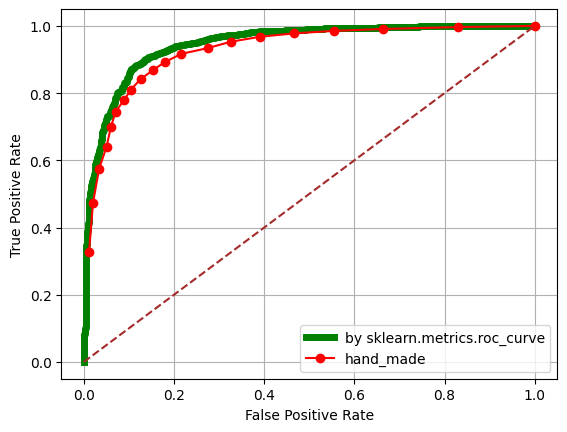

In [ ]:
plt.plot( fpr, tpr, color = 'green',  linewidth =5 , label = 'by sklearn.metrics.roc_curve' )
plt.plot( fprs, recalls, color='red' , label = 'hand_made', marker='o')
plt.plot(a,b, color='brown', linestyle='dashed' )
plt.legend( loc = 0 )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.show()

###7. Постройте график Precision-Recall, используя метрики, посчитанные в п. 5.

In [ ]:
# Для практики построим график, используя ф-ю из библиотеки
from sklearn.metrics import precision_recall_curve

In [ ]:
pr, re, thres = precision_recall_curve(y_test, predictions[:, 1])

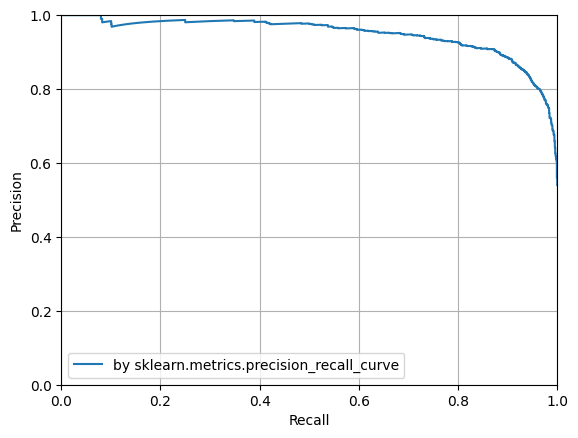

In [ ]:
plt.plot(re, pr,  label = 'by sklearn.metrics.precision_recall_curve')
plt.grid()
plt.xlim(0,1)
plt.ylim(0,1)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend( loc = 0 )
plt.show()

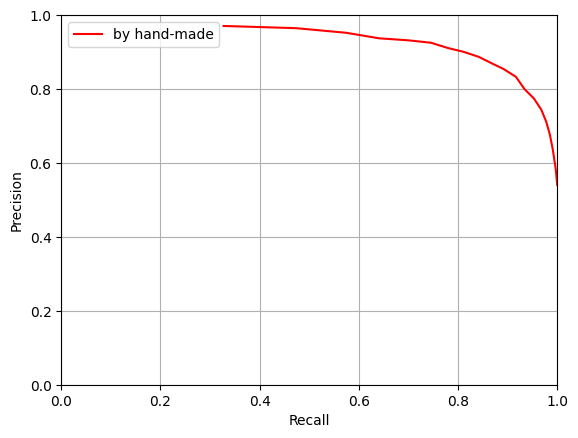

In [ ]:
# построим график на основании расчетов
plt.plot(recalls, precisions,  color='red' ,  label = 'by hand-made')
plt.grid()
plt.xlim(0,1)
plt.ylim(0,1)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend( loc = 0 )
plt.show()

###8. *Вычислите значение ROC-AUC метрики, используя метрики, посчитанные в п. 5.

In [ ]:
roc_auc=0
for i in range(len(fprs)-1):
  roc_auc +=(recalls[i+1] + recalls[i])/2*(fprs[i]-fprs[i+1])

In [ ]:
roc_auc

0.9260871057254063

Т.к вычисление велось приближенным способом, путем разбиения фигуры под кривой на трапеции и суммирования их площадей, метрика roc_auc (0.9254171292124922) получилась меньше, чем  вычисленная при помощи ф-ии auc и roc_auc_score (0.9473068859539565). В принципе, у нас незначительный дисбаланс между метками в целевом классе, поэтому можно пользоваться ею, тем более что ее значение близко к 1. 

In [ ]:
# Для практики рассчитаем и вторую метрику pr_auc, тем более, что некоторый дисбаланс между метками класса имеется. 
# площадь под кривой pr_auc
average_precision_score( y_test, predictions[:, 1] )

0.9491167202231695

### 9. Сформулируйте выводы по проделанной работе:
a. как по полученным графикам сделать вывод о качестве модели? Как вы оцениваете обученную модель исходя из подсчитанных метрик?

b. *может ли ROC-кривая проходить ниже диагонали?

a. По полученным графикам можно сделать вывод о том, что модель хорошая. Площадь под кривой близка к 1. О качестве модели говорят и полученные метрики precision и recall, величина которых также близка 1

b. Если ROC-кривая проходит ниже диагонали, это означает, что площадь под кривой будет менее 0.5. Значение менее 0,5 говорит, что классификатор действует с точностью до наоборот: если положительные назвать отрицательными и наоборот, классификатор будет работать лучше.